# Setup

In [3]:
#imports
import matplotlib.pyplot as plt
 
import pandas as pd
import itertools
import numpy as np
 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
)
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import folium 

from itertools import combinations
 
#loading the Dataset into a pandas dataframe
df = pd.read_csv('Airlines.csv')
allAirports = pd.read_csv('AllAirports.csv')

# Stage 1: Data Analysis

First, we want to know what the data is like:
Are there any outliers?
Do we need a scaler?
Which columns could have a high influence on the delay and which ones not?
Are there empty tuples?


data head:
   id Airline  Flight AirportFrom AirportTo  DayOfWeek  Time  Length  Delay
0   1      CO     269         SFO       IAH          3    15     205      1
1   2      US    1558         PHX       CLT          3    15     222      1
2   3      AA    2400         LAX       DFW          3    20     165      1
3   4      AA    2466         SFO       DFW          3    20     195      1
4   5      AS     108         ANC       SEA          3    30     202      0

data shape:
(539383, 9)

data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Le

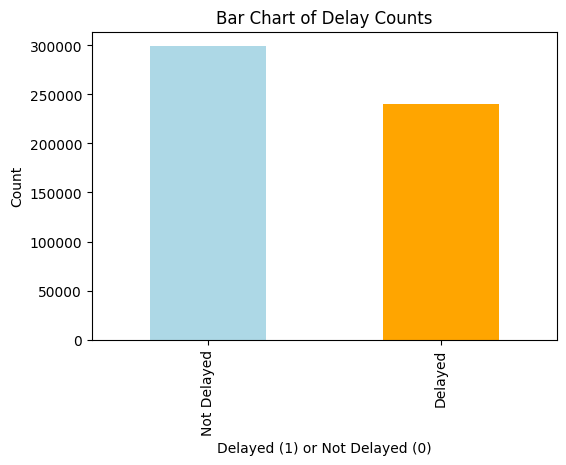

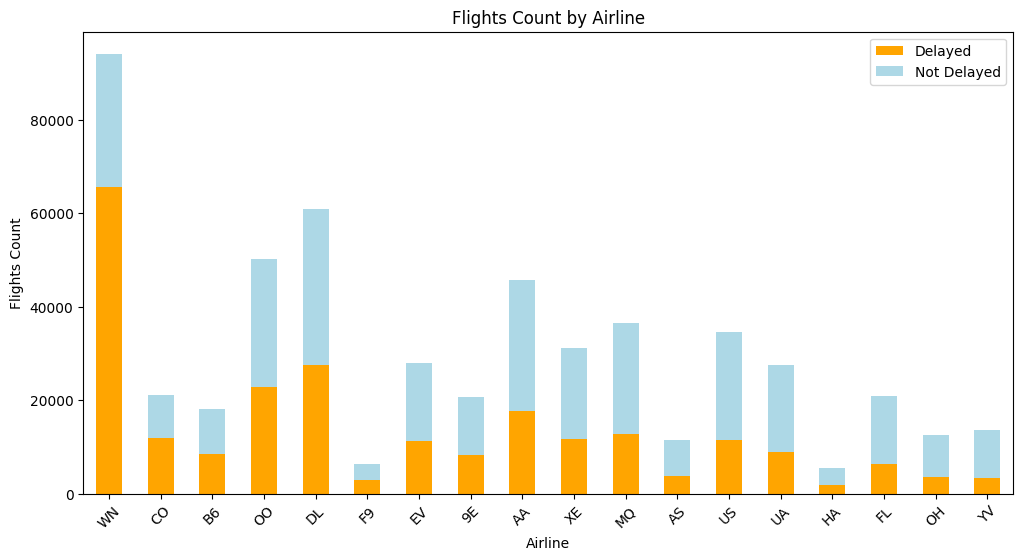

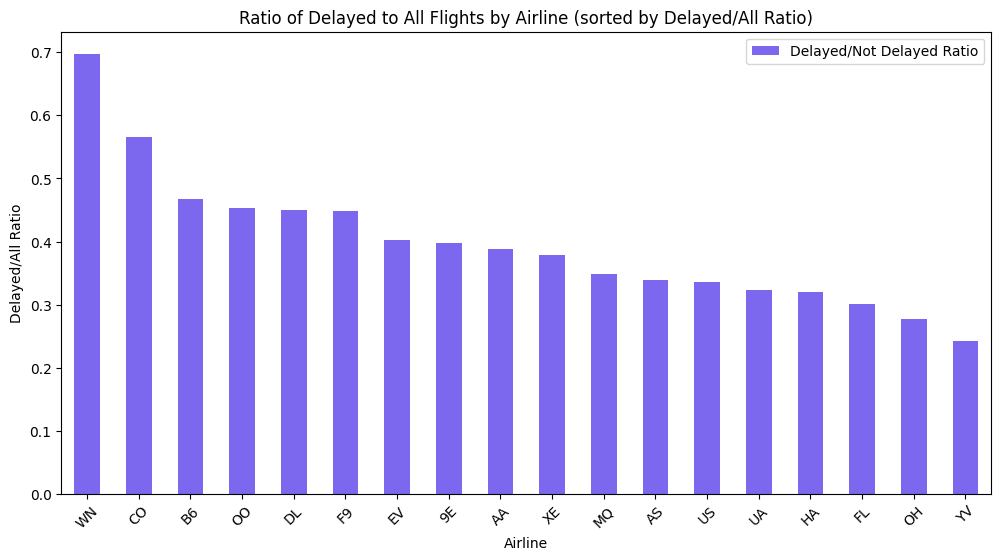

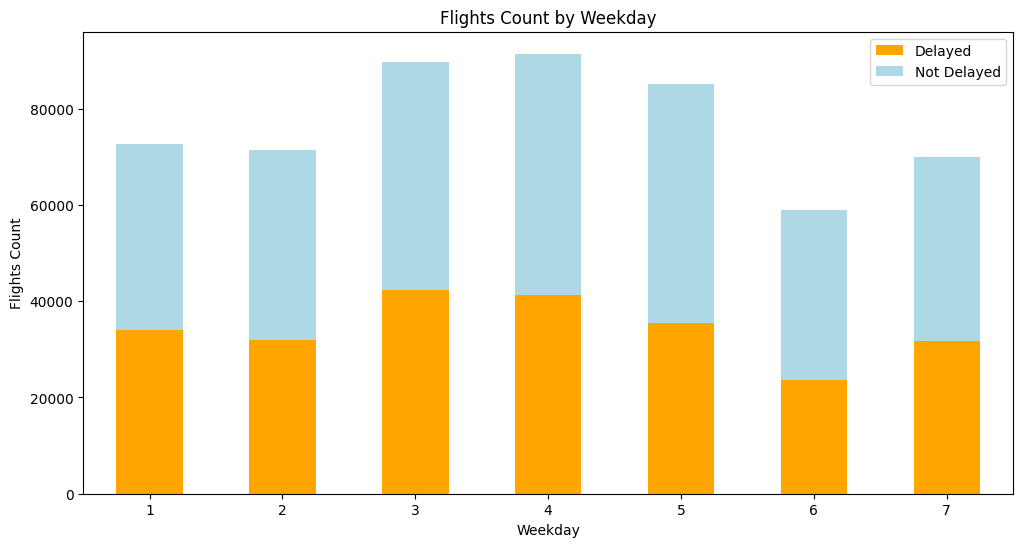

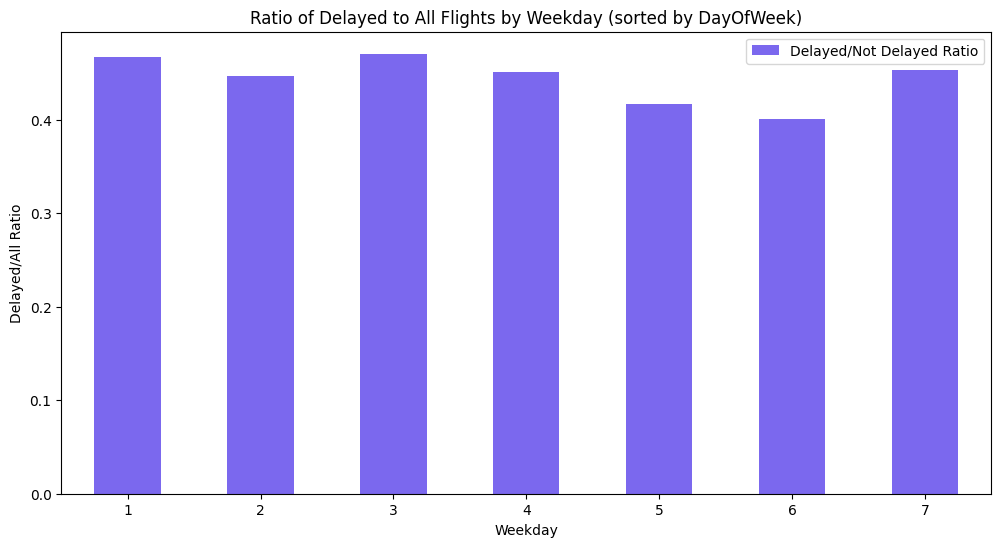

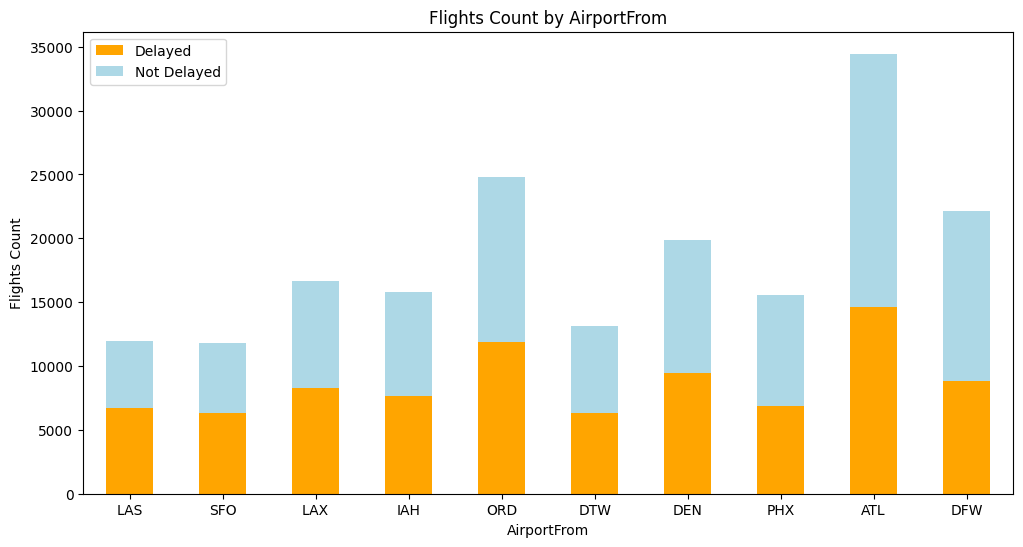

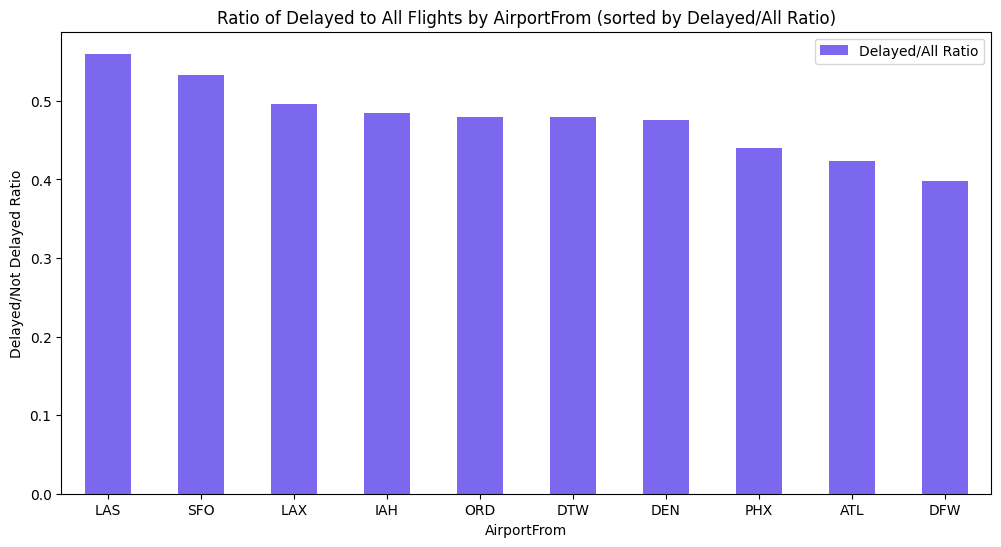

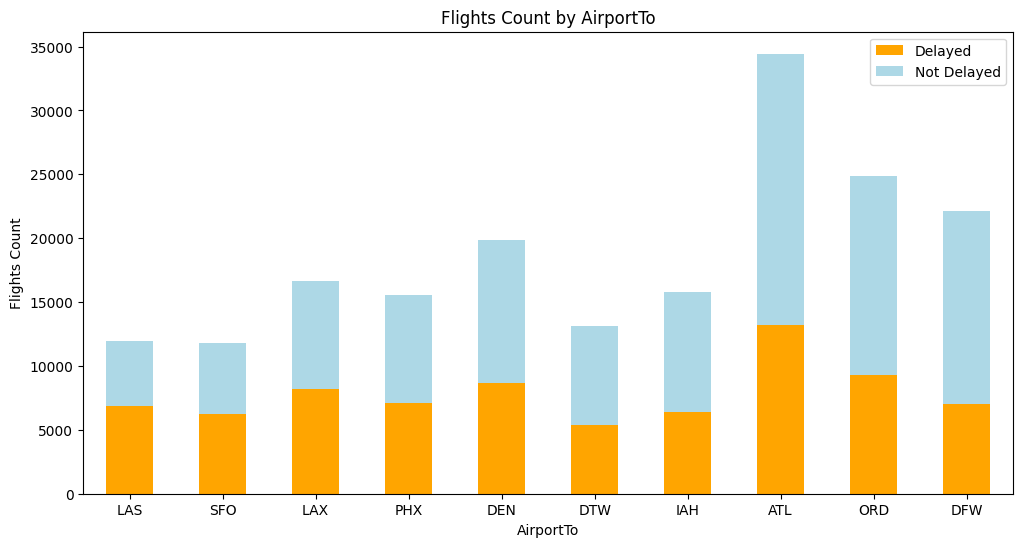

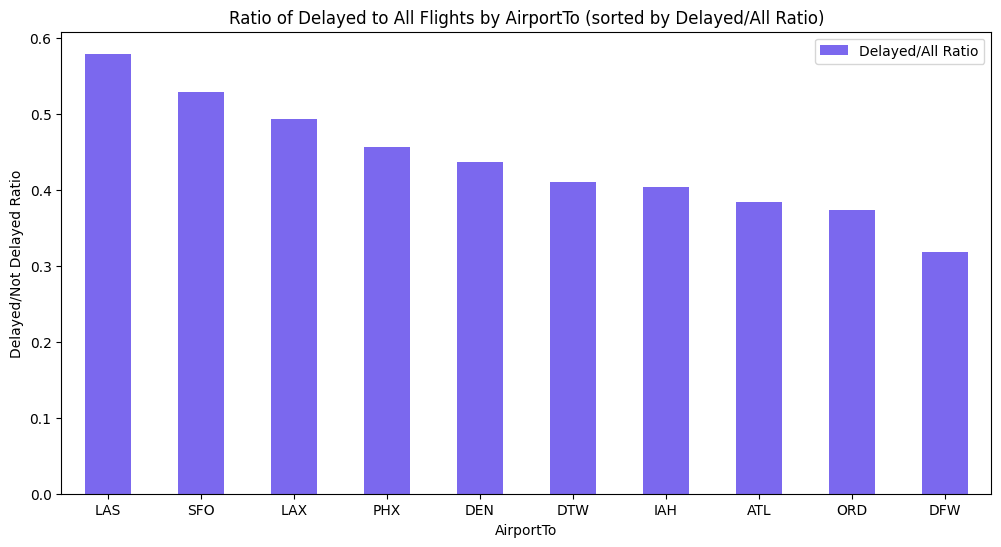

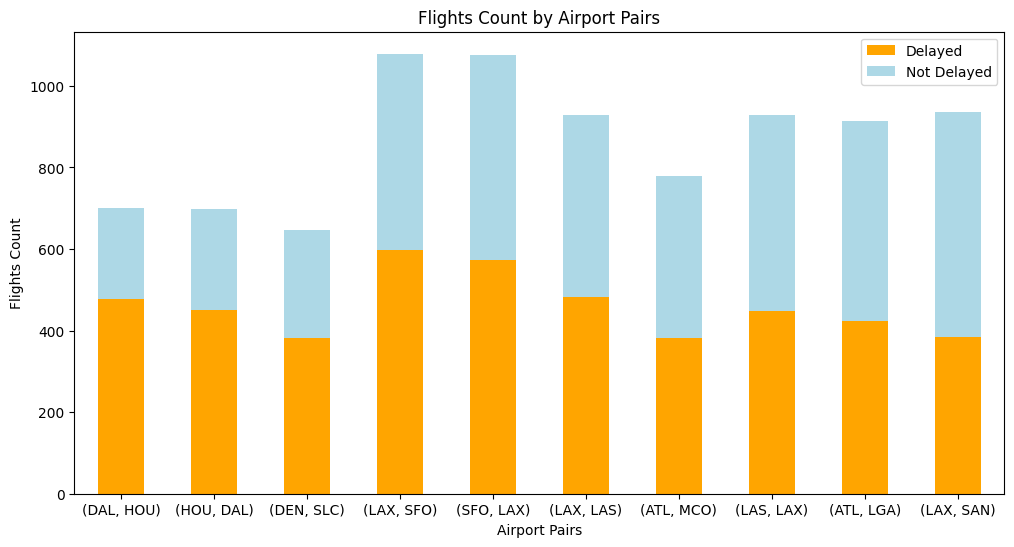

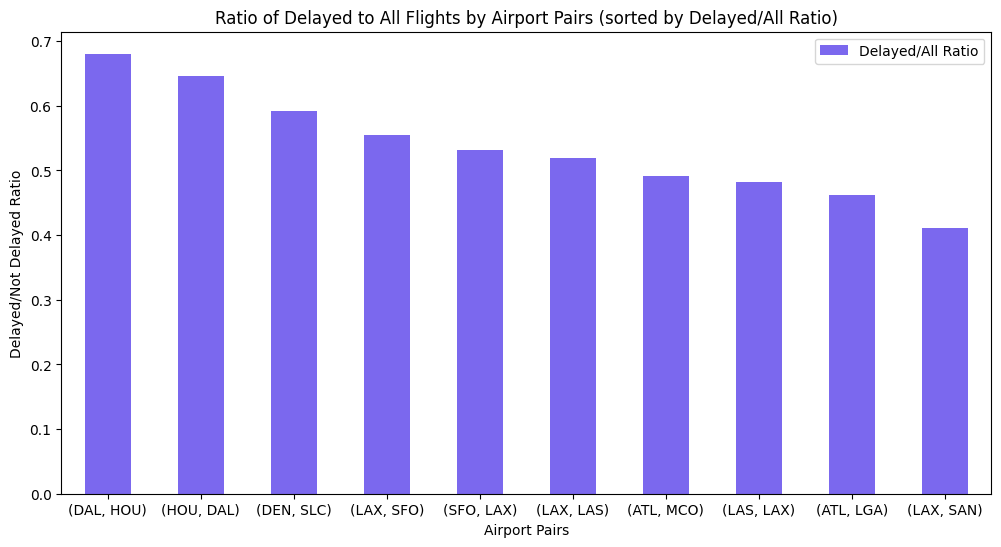

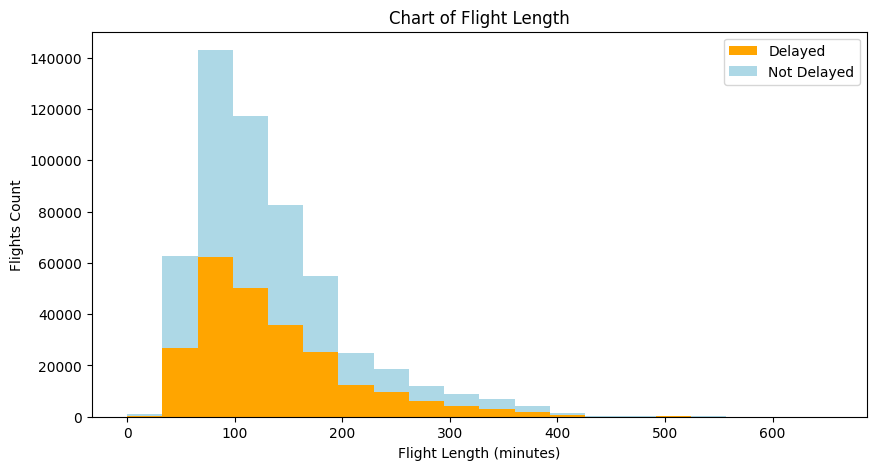

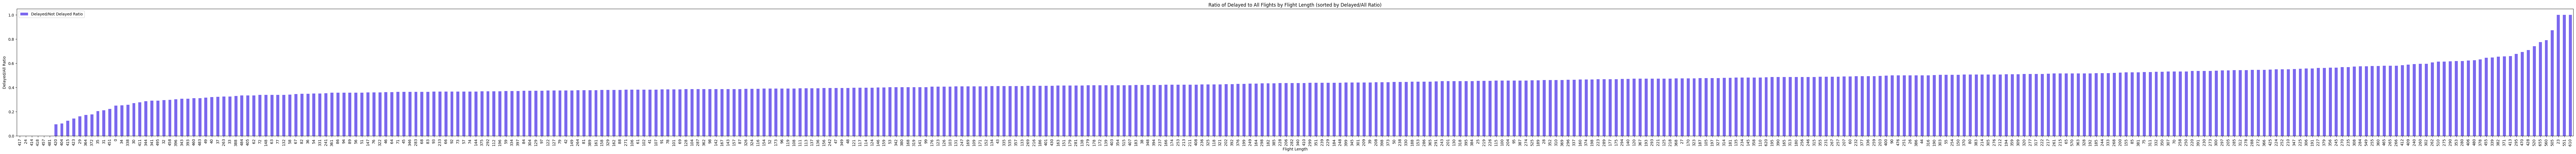

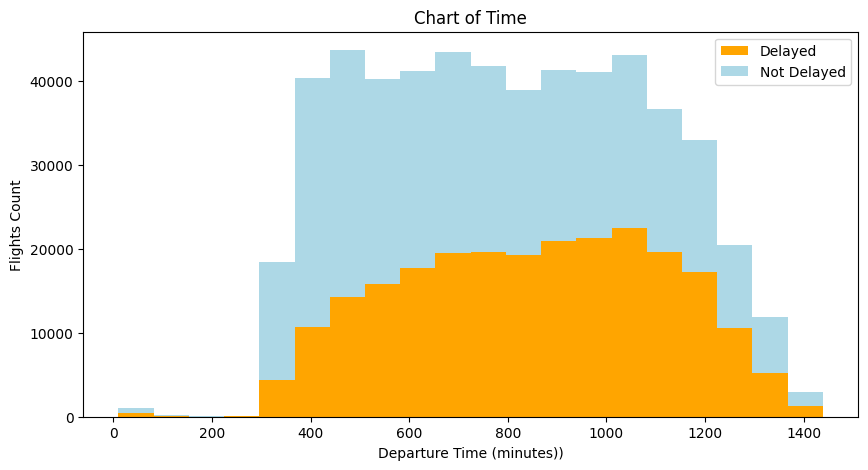

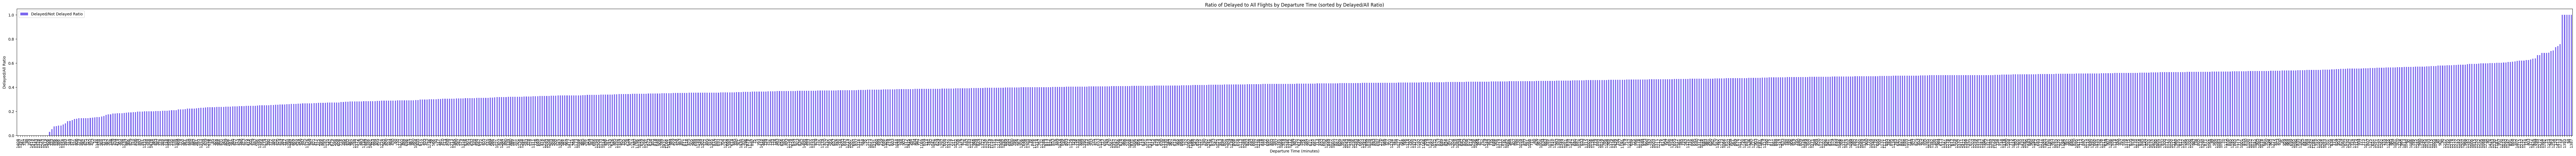

In [17]:
# Structure of the data:

print("\ndata head:")
print(df.head()) #Check table composition

print("\ndata shape:")
print(df.shape) #How many entries are there? (Get height and width of Dataset)

print("\ndata info:")
print(df.info()) #Check for empty datatuple

print("\ndata description:")
print(df.describe()) #Data visualization -> Mean etc.

# Are there duplicates in our data?
duplicate_values = df.duplicated()
if duplicate_values.any:
    print("\nNo duplicates")
else:    
    print("\nDuplicates found")
    print(duplicate_values)

# Are there duplicated ids in our data?
duplicate_values = df['id'].duplicated()
if duplicate_values.any:
    print("\nNo duplicates id")
else:    
    print("\nDuplicates found id")
    print(duplicate_values)

#------------------------------------
# Interesting graphs:

colors = ['orange', 'lightblue']

#Delay Count
delay_counts = df['Delay'].value_counts()
print(delay_counts)

# Get the total number of flights
total_flights = delay_counts.sum()

# Calculate the percentage of flights not delayed
percent_no_delay = (delay_counts[0] / total_flights) * 100

# Print the result
print(f"The percentage of flights that are not delayed is {percent_no_delay:.2f}%")

# 1. Chart of Delay Counts
plt.figure(figsize=(6, 4))
delay_counts.plot(kind='bar', color=['lightblue', 'orange']) 
plt.xlabel('Delayed (1) or Not Delayed (0)')
plt.ylabel('Count')
plt.title('Bar Chart of Delay Counts')
plt.xticks([0, 1], ['Not Delayed', 'Delayed'])
plt.show()

#--------------------------------------

#2 Chart of Airline and Delay Count
delay_counts_by_airline = df.groupby('Airline')['Delay'].agg(['sum', 'count'])
delay_counts_by_airline['ratio'] = delay_counts_by_airline['sum'] / delay_counts_by_airline['count']
delay_counts_by_airline = delay_counts_by_airline.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
delay_counts_by_airline['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(delay_counts_by_airline['count'] - delay_counts_by_airline['sum']).plot(kind='bar', bottom=delay_counts_by_airline['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('Airline')
plt.ylabel('Flights Count')
plt.title('Flights Count by Airline')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=45)
plt.show()

# Ratio of Delayed to Not Delayed Flights by Airline
plt.figure(figsize=(12, 6))
delay_counts_by_airline['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Airline')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Airline (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=45)
plt.show()

#------------------------------------------

# 3. Chart of DayOfWeek vs. Delay Counts
day_counts = df.groupby('DayOfWeek')['Delay'].agg(['sum', 'count'])
day_counts['ratio'] = day_counts['sum'] / day_counts['count']
day_counts = day_counts.sort_values(by='DayOfWeek', ascending=True)

plt.figure(figsize=(12, 6))
day_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(day_counts['count'] - day_counts['sum']).plot(kind='bar', bottom=day_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('Weekday')
plt.ylabel('Flights Count')
plt.title('Flights Count by Weekday')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by Airline
plt.figure(figsize=(12, 6))
day_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Weekday')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Weekday (sorted by DayOfWeek)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=0)
plt.show()

#------------------------------------------

# 4.1 Chart of AirportFrom and Delay Counts
airportFrom_counts = df.groupby(['AirportFrom'])['Delay'].agg(['sum', 'count']).nlargest(10, 'sum')
airportFrom_counts['ratio'] = airportFrom_counts['sum'] / airportFrom_counts['count']
airportFrom_counts = airportFrom_counts.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
airportFrom_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(airportFrom_counts['count'] - airportFrom_counts['sum']).plot(kind='bar', bottom=airportFrom_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('AirportFrom')
plt.ylabel('Flights Count')
plt.title('Flights Count by AirportFrom')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by AirportFrom
plt.figure(figsize=(12, 6))
airportFrom_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('AirportFrom')
plt.ylabel('Delayed/Not Delayed Ratio')
plt.title('Ratio of Delayed to All Flights by AirportFrom (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/All Ratio'])
plt.xticks(rotation=0)
plt.show()


# 4.2 Chart of AirportTo and Delay Counts
airportTo_counts = df.groupby(['AirportTo'])['Delay'].agg(['sum', 'count']).nlargest(10, 'sum')
airportTo_counts['ratio'] = airportTo_counts['sum'] / airportTo_counts['count']
airportTo_counts = airportTo_counts.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
airportTo_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(airportTo_counts['count'] - airportTo_counts['sum']).plot(kind='bar', bottom=airportTo_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('AirportTo')
plt.ylabel('Flights Count')
plt.title('Flights Count by AirportTo')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by AirportTo
plt.figure(figsize=(12, 6))
airportTo_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('AirportTo')
plt.ylabel('Delayed/Not Delayed Ratio')
plt.title('Ratio of Delayed to All Flights by AirportTo (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/All Ratio'])
plt.xticks(rotation=0)
plt.show()


# 4.3 Chart of Airport Pairs and Delay Counts
airport_pairs_counts = df.groupby(['AirportFrom', 'AirportTo'])['Delay'].agg(['sum', 'count']).nlargest(10, 'sum')
airport_pairs_counts['ratio'] = airport_pairs_counts['sum'] / airport_pairs_counts['count']
airport_pairs_counts = airport_pairs_counts.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(12, 6))
airport_pairs_counts['sum'].plot(kind='bar', color=colors[0], label='Delayed')
(airport_pairs_counts['count'] - airport_pairs_counts['sum']).plot(kind='bar', bottom=airport_pairs_counts['sum'], color=colors[1], label='Not Delayed')
plt.xlabel('Airport Pairs')
plt.ylabel('Flights Count')
plt.title('Flights Count by Airport Pairs')
plt.legend(['Delayed', 'Not Delayed'])
plt.xticks(rotation=0)
plt.show()

# Ratio of Delayed to Not Delayed Flights by Airport Pairs
plt.figure(figsize=(12, 6))
airport_pairs_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Airport Pairs')
plt.ylabel('Delayed/Not Delayed Ratio')
plt.title('Ratio of Delayed to All Flights by Airport Pairs (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/All Ratio'])
plt.xticks(rotation=0)
plt.show()

#------------------------------------------

# 5. Chart of Flight Length and Delay Counts
plt.figure(figsize=(10, 5))
plt.hist([df[df['Delay'] == 1]['Length'], df[df['Delay'] == 0]['Length']], bins=20, color=colors, stacked=True)
plt.xlabel('Flight Length (minutes)')
plt.ylabel('Flights Count')
plt.title('Chart of Flight Length')
plt.legend(['Delayed', 'Not Delayed'])
plt.show()

length_counts = df.groupby(['Length'])['Delay'].agg(['sum', 'count'])
length_counts['ratio'] = length_counts['sum'] / length_counts['count']
length_counts = length_counts.sort_values(by='ratio', ascending=True)

# Ratio of Delayed to Not Delayed Flights by Flight Length
plt.figure(figsize=(120, 6))
length_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Flight Length')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Flight Length (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=90)
plt.show()

#------------------------------------------

# 6. Chart of Time and Delay Counts
plt.figure(figsize=(10, 5))
plt.hist([df[df['Delay'] == 1]['Time'], df[df['Delay'] == 0]['Time']], bins=20, color=colors, stacked=True)
plt.xlabel('Departure Time (minutes))')
plt.ylabel('Flights Count')
plt.title('Chart of Time')
plt.legend(['Delayed', 'Not Delayed'])
plt.show()

time_counts = df.groupby(['Time'])['Delay'].agg(['sum', 'count'])
time_counts['ratio'] = time_counts['sum'] / time_counts['count']
time_counts = time_counts.sort_values(by='ratio', ascending=True)

# Ratio of Delayed to Not Delayed Flights by Time
plt.figure(figsize=(120, 6))
time_counts['ratio'].plot(kind='bar', color="mediumslateblue")
plt.xlabel('Departure Time (minutes)')
plt.ylabel('Delayed/All Ratio')
plt.title('Ratio of Delayed to All Flights by Departure Time (sorted by Delayed/All Ratio)')
plt.legend(['Delayed/Not Delayed Ratio'])
plt.xticks(rotation=90)
plt.show()




We printed the head of the data table to see whether we need an encoder or not. As we have columns filled with text rather than numbers, we decided to use an Ordinal Encoder.
On the basis of these graphs we decided to use a Standard Scaler to avert the different columns from having a different influence level in the Data Models (because the scales of the numbers are varying).
Also, on basis of the different ratios, we assume that the columns Airline, AirportTo, Length and Time have an actual impact on the delay. The rest of the columns might not be needed to be revised by the Data Model to get a good forecast. We will try that out later after deciding on a Model.

## Map

Does the country of an airport have an impact on the delay of a flight? --> Where are the airports?

In [3]:
dfFrom = df["AirportFrom"].unique()
dfTo = df["AirportTo"].unique()

# Concatenate those two arrays to one
dfAirports = np.concatenate((dfFrom, dfTo), axis=None)

# Remove duplicates
dfAirports = np.unique(dfAirports)
print("\nAirports count:")
print(dfAirports.shape)

# Convert dfAirports to a DataFrame
dfAirports = pd.DataFrame({'iata_code': dfAirports}) #iata_code is column of AllAirports.csv

# Convert 'iata_code' columns to strings
dfAirports['iata_code'] = dfAirports['iata_code'].astype(str)
allAirports['iata_code'] = allAirports['iata_code'].astype(str)

# Merge dataframes based on the 'iata_code' column
merged_dataframe = pd.merge(dfAirports, allAirports, on='iata_code', how='left')

print("\nmerged_dataframe:")
print(merged_dataframe.shape)


# Extract latitude and longitude from the 'coordinates' column
merged_dataframe[['longitude', 'latitude']] = merged_dataframe['coordinates'].str.split(', ', expand=True).astype(float)

# Create a folium map centered around the first entry
m = folium.Map(location=[merged_dataframe['latitude'].iloc[0], merged_dataframe['longitude'].iloc[0]], zoom_start=10)

# Add markers for each entry
for index, row in merged_dataframe.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(m)

# Display the map
m




Airports count:
(293,)

merged_dataframe:
(293, 12)


All of the airports are located in the USA. Therefore, we will not follow our thesis about the influence of the country any further.

# Stage 2: Data Preprocessing

We now prepare the data so that we can use it in the Data Models. 
As already mentioned above, we decided to apply an Ordinal Encoder and a MinMax Scaler. After that we make a train and test data split of 80% training and 20% test data.

In [4]:
# Select features and target variable (id is not needed)
features = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']
target = 'Delay'
X = df[features]
y = df[target]

#Preprossing of the data
encoder = preprocessing.OrdinalEncoder()
encoded = pd.DataFrame(encoder.fit_transform(X[['Airline', 'AirportFrom', 'AirportTo']]), columns = encoder.get_feature_names_out(['Airline', 'AirportFrom', 'AirportTo']))

X = X.drop(columns = ['Airline', 'AirportFrom', 'AirportTo'])
X = X.join(encoded)

# Separate continuous and categorical columns
continuous_cols = ['DayOfWeek', 'Time', 'Length']
categorical_cols = [col for col in X.columns if col not in continuous_cols]



# Instantiate MinMaxScaler
min_max_scaler = MinMaxScaler()

# Apply MinMaxScaler only to continuous columns
X[continuous_cols] = min_max_scaler.fit_transform(X[continuous_cols])


print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% testing

        DayOfWeek      Time    Length  Airline  AirportFrom  AirportTo
0        0.333333  0.003499  0.312977      4.0        253.0      135.0
1        0.333333  0.003499  0.338931     14.0        217.0       60.0
2        0.333333  0.006998  0.251908      1.0        154.0       80.0
3        0.333333  0.006998  0.297710      1.0        253.0       80.0
4        0.333333  0.013996  0.308397      2.0         14.0      252.0
...           ...       ...       ...      ...          ...        ...
539378   0.666667  1.000000  0.497710      4.0        203.0      264.0
539379   0.666667  1.000000  0.465649      8.0        252.0       16.0
539380   0.666667  1.000000  0.389313      8.0        253.0      184.0
539381   0.666667  1.000000  0.477863     13.0        128.0      253.0
539382   0.666667  1.000000  0.459542     14.0        154.0      216.0

[539383 rows x 6 columns]
0         1
1         1
2         1
3         1
4         0
         ..
539378    0
539379    0
539380    0
539381    1
5

# Data Models

In the following, we tried out different data models and checked the accuracy, precision, recall and f1. To decide on a specific model we agreed on using the best accuracy. We primarily did not decide for precision, recall or f1 because these measurements are especially used for infrequent data which we do not have. We nearly have the same amounts of delayed and undelayed flights.

Each time, we also plotted the accuracy of the training data to be sure from which point on the model is overfitting.

## KNN

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from scipy.stats import randint

# Create arrays
k_count = []
precisions = []
recalls = []
f1_scores = []
accuracies = []
results_array = []
cv_scores = []


# Define parameters for RandomizedSearchCV
param_dist = {
    'algorithm': ['ball_tree'],  # ball_tree algorithm for shorter runtime
    'n_jobs': [-1], #use all cores --> shorter runtime
    'weights': ['uniform', 'distance'], #uniform: all points weighted equally | distance: closer neighbors are weighted more
    'p': [1, 2, 3], #distance metric used to calculate the distance between points | 1 = manhattan, 2 = euclidean, 3 = minkowski
}

# Number of random samples
n_iter_search = 6

# Define the KFold for the outer loop
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

#loop for all k
k_range = 21
for k in range (1, k_range): #k in range 1-20 as rule of thumb
    k_count.append(k)

    # Create a KNN Classifier
    knn_estimator = KNeighborsClassifier(n_neighbors=k)

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=knn_estimator, 
        param_distributions=param_dist, 
        n_iter=n_iter_search, 
        cv=5, 
        scoring='accuracy', 
        error_score='raise',
        random_state=42
    )
    random_search.fit(X_train, y_train)

    # Perform nested cross-validation
    cv_score = cross_val_score(random_search, X_train, y_train, cv=kfolds, scoring=make_scorer(accuracy_score))

    # Test on the other 20%
    clf = Pipeline([('classifier', random_search.best_estimator_)])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results in array
    results_array.append([k, accuracy, cv_score.mean(), precision, recall, f1, random_search.best_params_])
    accuracies.append(accuracy)
    k_count.append(k)
    cv_scores.append(cv_score.mean())

    print(f"K: {results_array[-1][0]}, Accuracy: {results_array[-1][1]}, CV Accuracy: {results_array[-1][2]}, Precision: {results_array[-1][3]}, Recall: {results_array[-1][4]}, f1: {results_array[-1][5]}, Best Parameters: {results_array[-1][6]}")


#plot for depth and accuracy
plt.plot(k_count, accuracies, marker='o', label="CV Accuracy (20% Test Data)")
plt.plot(k_count, cv_scores, marker='o', label="Nested CV Accuracy")
plt.legend()
plt.title('K vs. Accuracy and Cross-Validation Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.savefig("graphs/KNN.pdf")
plt.show()

c:\Users\lisa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lisa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lisa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lisa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iter

K: 1, Accuracy: 0.593157021422546, CV Accuracy: 0.5920821487128941, Precision: 0.5428977094773767, Recall: 0.5417100712529689, f1: 0.5423032401372392, Best Parameters: {'weights': 'uniform', 'p': 1, 'n_jobs': -1, 'algorithm': 'ball_tree'}
K: 1, Accuracy: 0.593157021422546, CV Accuracy: [0.59241964 0.59342302 0.59185873 0.59167333 0.59103603], Precision: 0.5428977094773767, Recall: 0.5417100712529689, f1: 0.5423032401372392, Best Parameters: {'weights': 'uniform', 'p': 1, 'n_jobs': -1, 'algorithm': 'ball_tree'}


c:\Users\lisa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

## Naive Bayes

In [5]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB
# Create an instance of CategoricalNB with fixed parameters
categorical_classifier = CategoricalNB()
categorical_classifier.fit(X_train[categorical_cols], y_train)

# Create an instance of GaussianNB with fixed parameters
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(X_train[continuous_cols], y_train)

# Create a function for combining predictions using majority vote
def majority_vote_ensemble(X_test, classifiers):
    predictions = np.array([classifier.predict(X_test) for classifier in classifiers])
    return (np.sum(predictions, axis=0) >= (len(classifiers) / 2)).astype(int)

# Create an ensemble of classifiers
classifiers = [categorical_classifier, gaussian_classifier]

# Cross-validation for CategoricalNB
categorical_cv_accuracy = cross_val_score(categorical_classifier, X_train[categorical_cols], y_train, cv=5, scoring=make_scorer(accuracy_score),n_jobs=-1)
print("CategoricalNB Cross-Validated Accuracy:", np.mean(categorical_cv_accuracy))

# Cross-validation for GaussianNB
gaussian_cv_accuracy = cross_val_score(gaussian_classifier, X_train[continuous_cols], y_train, cv=5, scoring=make_scorer(accuracy_score),n_jobs=-1)
print("GaussianNB Cross-Validated Accuracy:", np.mean(gaussian_cv_accuracy))

# Combine cross-validated scores
combined_cv_accuracy = np.mean([categorical_cv_accuracy, gaussian_cv_accuracy])
print("Combined Cross-Validated Accuracy:", combined_cv_accuracy)

# Make predictions on the test set
y_pred_cat = categorical_classifier.predict(X_test[categorical_cols])
y_pred_gaussian = gaussian_classifier.predict(X_test[continuous_cols])

# Combine predictions using majority vote
y_pred_combined = (y_pred_cat + y_pred_gaussian) >= 1

# Evaluate the performance

precision = precision_score(y_test, y_pred_combined)
recall = recall_score(y_test, y_pred_combined)
f1 = f1_score(y_test, y_pred_combined, average="weighted")

# Print the evaluation metrics

print("Precision:", precision)
print("Recall:", recall) 
print("F1 Score:", f1)



CategoricalNB Cross-Validated Accuracy: 0.6249600229601575
GaussianNB Cross-Validated Accuracy: 0.5658577143122295
Combined Cross-Validated Accuracy: 0.5954088686361935
Precision: 0.5470704050752908
Recall: 0.6252135505646068
F1 Score: 0.6041146968161575


## Neural Network

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint
import random

# Define the hyperparameters
param_dist = {"hidden_layer_sizes": [(50, 50), (100, 100), (200,)], #3 Layers with 50 Nodes, 2 with 100, 1 with 200
              "learning_rate_init": [0.1, 0.01, 0.001, 0.0001],
              "max_iter": randint(100, 1000)}

# Initialize MLPClassifier
neuralnet = MLPClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(neuralnet, param_distributions=param_dist,
                                   n_iter=10, cv=5, random_state = 42) # cv = 5 --> cross validation 

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", random_search.best_params_)

# Make predictions on the testing set
y_pred = random_search.predict(X_test)

# Calculate and print the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Calculate and print precision, recall, and f1-score
precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

print(f"Neural Network:, Test Accuracy:  {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}")

NameError: name 'X_train' is not defined

Now, our two best models will follow. Their accuracies are very similar. This is why we also decided to decide in a second step on f1 and precision. 
For our business case, precision is more important than recall because it is worse when the model is wrong with the prediction that a flight will be late than when it is right about being late.

## Random Forest

Max Depth: 1, Test Accuracy:  0.6083131714823363, Precision: 0.6379707916986933, Recall: 0.2766781949247885, f1: 0.3859679716336792
Max Depth: 1, Train Accuracy: 0.6089996431104087
Max Depth: 2, Test Accuracy:  0.6153489622440372, Precision: 0.6692872390274379, Recall: 0.2678236593191383, f1: 0.38256082136745784
Max Depth: 2, Train Accuracy: 0.6157921326702294
Max Depth: 3, Test Accuracy:  0.6223940228222884, Precision: 0.7066757725798191, Recall: 0.2586982790949623, f1: 0.3787460537754122
Max Depth: 3, Train Accuracy: 0.6218546207932218
Max Depth: 4, Test Accuracy:  0.6253974433845955, Precision: 0.7197474367143601, Recall: 0.2588649527063628, f1: 0.38077871929636387
Max Depth: 4, Train Accuracy: 0.625055039790872
Max Depth: 5, Test Accuracy:  0.6346301806687246, Precision: 0.734239397412805, Recall: 0.2802616775698987, f1: 0.40567559824484684
Max Depth: 5, Train Accuracy: 0.6332472781374998
Max Depth: 6, Test Accuracy:  0.6387923282998229, Precision: 0.7126777809173966, Recall: 0.315

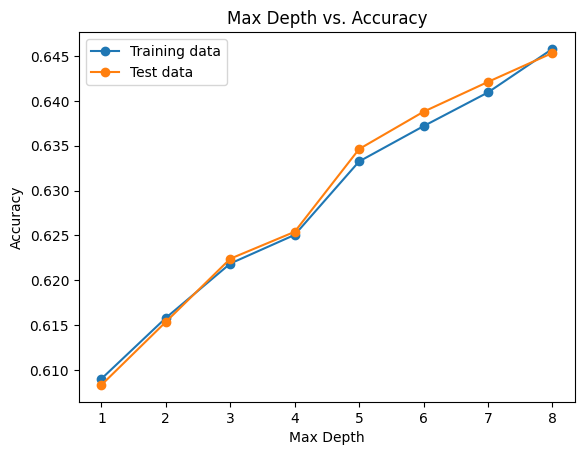

In [8]:
#Create a Random Forest classifier within a pipeline

clf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# define the parameter grid for randomized search

param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth' : [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__criterion' : ['gini', 'entropy']
}


# setup the randomized search
random_search = RandomizedSearchCV(estimator = clf , param_distributions = param_grid, 
                                   n_iter = 15, cv = kfold, random_state=42, n_jobs = -1)

# fit it
random_search.fit(X_train, y_train)

# get the best params
best_params = random_search.best_params_

print(best_params)

score = cross_val_score(random_search,X_train, y_train, cv = kfold, scoring = make_scorer(accuracy_score), n_jobs = -1)
print("Cross Validated score (mean): " + str(score.mean()))

# Make predictions on the testing set (20%)
clfTest= random_search.best_estimator_ #Create a classifier with the best esimator of the random search

y_pred = clfTest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of the best estimator (on the 20% test Data:)", accuracy)

Random Forest Random Search and Nested Cross Validation

Was tried but turned out to be too computionally expensive...

In [7]:
#Create a Random Forest classifier within a pipeline
clf = Pipeline([
    ('classifier', RandomForestClassifier())])


# define the parameter grid for randomized search
param_grid = {
    'classifier__n_estimators': [10, 20, 50, 100, 200],
    'classifier__max_depth' : [None, 10, 20, 30],
    'classifier__min_samples_split': range(2, 11),
    'classifier__min_samples_leaf': range(1, 11),
    'classifier__criterion' : ['gini', 'entropy']
}

# setup the randomized search
random_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid, 
                                   n_iter = 100, cv = 3, random_state=42, n_jobs = -1)

# fit it
random_search.fit(X_train, y_train)

# get the best params
best_params = random_search.best_params_

# ------------------------------------------------
# Nested Cross validation

# setup k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# use the best model from random_search in nested cross-validation
nested_score = cross_val_score(random_search, X, y, cv=kfold)

print("Nested cross-validation score: ", np.mean(nested_score))

# Make predictions on the testing set
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

## Decision Tree

Max Depth: 1, Test Accuracy:  0.5956876813407863, Precision: 0.5787789443405724, Recall: 0.3353681403391808, f1: 0.4246669304841049
Max Depth: 1, Train Accuracy: 0.5967054919282698
Max Depth: 2, Test Accuracy:  0.6247578260426226, Precision: 0.700351774864087, Recall: 0.2737614067252802, f1: 0.3936488915518274
Max Depth: 2, Train Accuracy: 0.6232566870449079
Max Depth: 3, Test Accuracy:  0.6261668381582729, Precision: 0.7691605839416058, Recall: 0.22832201341722572, f1: 0.35211901166340004
Max Depth: 3, Train Accuracy: 0.6243945623004084
Max Depth: 4, Test Accuracy:  0.6309500634982433, Precision: 0.6135556542004217, Recall: 0.46074836451518814, f1: 0.5262844768092144
Max Depth: 4, Train Accuracy: 0.6278128229966675
Max Depth: 5, Test Accuracy:  0.6377633786627362, Precision: 0.6583590726736962, Recall: 0.3863494312263011, f1: 0.4869428215059411
Max Depth: 5, Train Accuracy: 0.6368254439103975
Max Depth: 6, Test Accuracy:  0.6401364516996209, Precision: 0.6667393437261528, Recall: 0.38

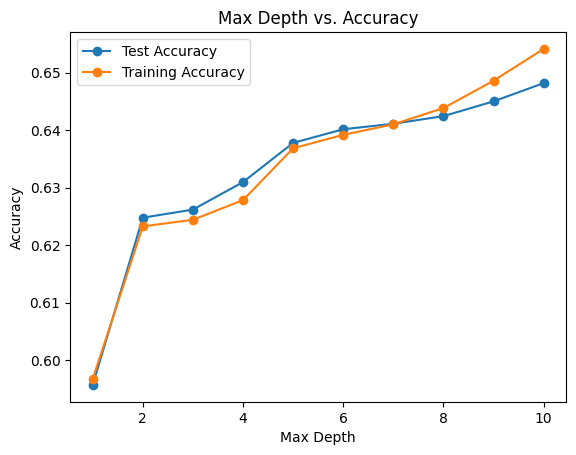

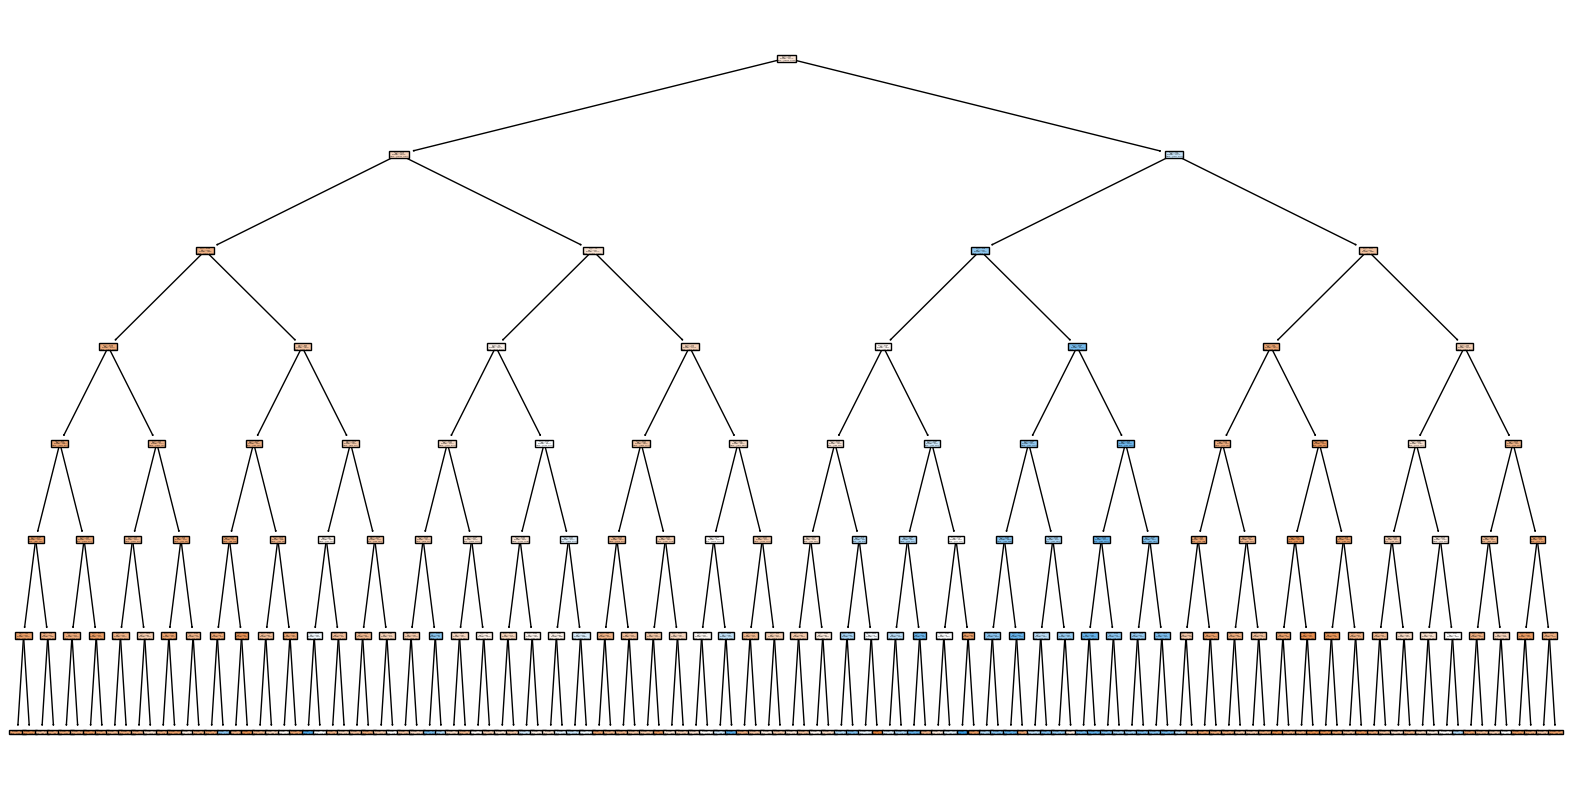

In [33]:
# Create arrays to store max_depth and corresponding accuracies
depths = []
accuracies = []
trainingAccuracies = []

# Loop through max depths from 1 to 10
for max_tree_depth in range(1, 11):

    # Create a Decision Tree classifier within a pipeline
    clf = Pipeline([
        ('classifier', DecisionTreeClassifier(max_depth=max_tree_depth, random_state=42))
    ])

    # Train the classifier on the training set
    clf.fit(X_train, y_train)

    if max_tree_depth == 7:
        clfSeven = clf

    # Make predictions on the testing set
    y_pred = clf.predict(X_test)
    y_test_pred = clf.predict(X_train)

    # Calculate the accuracy, precision, recall and f1 of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    trainAccuracy = accuracy_score(y_train, y_test_pred)

    print(f"Max Depth: {max_tree_depth}, Test Accuracy:  {accuracy}, Precision: {precision}, Recall: {recall}, f1: {f1}")
    print(f"Max Depth: {max_tree_depth}, Train Accuracy: {trainAccuracy}")

    # Store depth and accuracy in arrays
    depths.append(max_tree_depth)
    accuracies.append(accuracy)
    trainingAccuracies.append(trainAccuracy)

# Plotting the graph

print("\n")
print(accuracies)
print(trainingAccuracies)
print("\n")


plt.plot(depths, accuracies, marker='o', label = "Test Accuracy")
plt.plot(depths, trainingAccuracies, marker ='o', label = "Training Accuracy")
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("graphs/dtAcc.pdf")
plt.show()

# Plot the decision tree with depth 7
plt.figure(figsize=(20, 10))
plot_tree(clfSeven['classifier'], filled=True)
plt.savefig("graphs/dt.pdf")
plt.show()

e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\

[3, 0.6261668381582729, 0.6240307257951163, 0.7691605839416058, 0.22832201341722572, 0.35211901166340004, {'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}]


<Figure size 1000x1000 with 0 Axes>

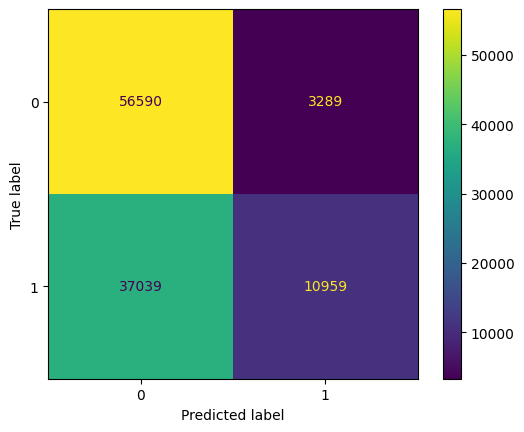

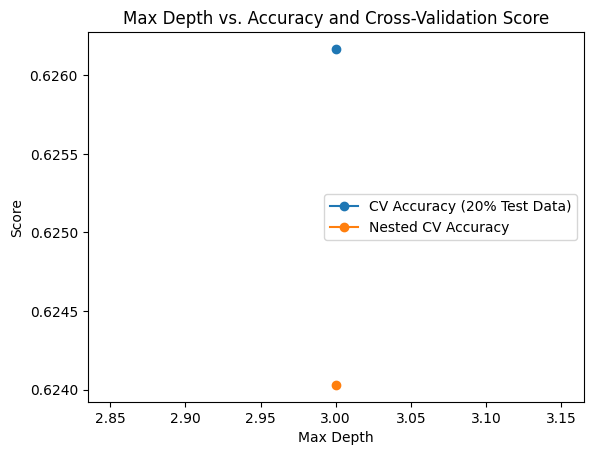

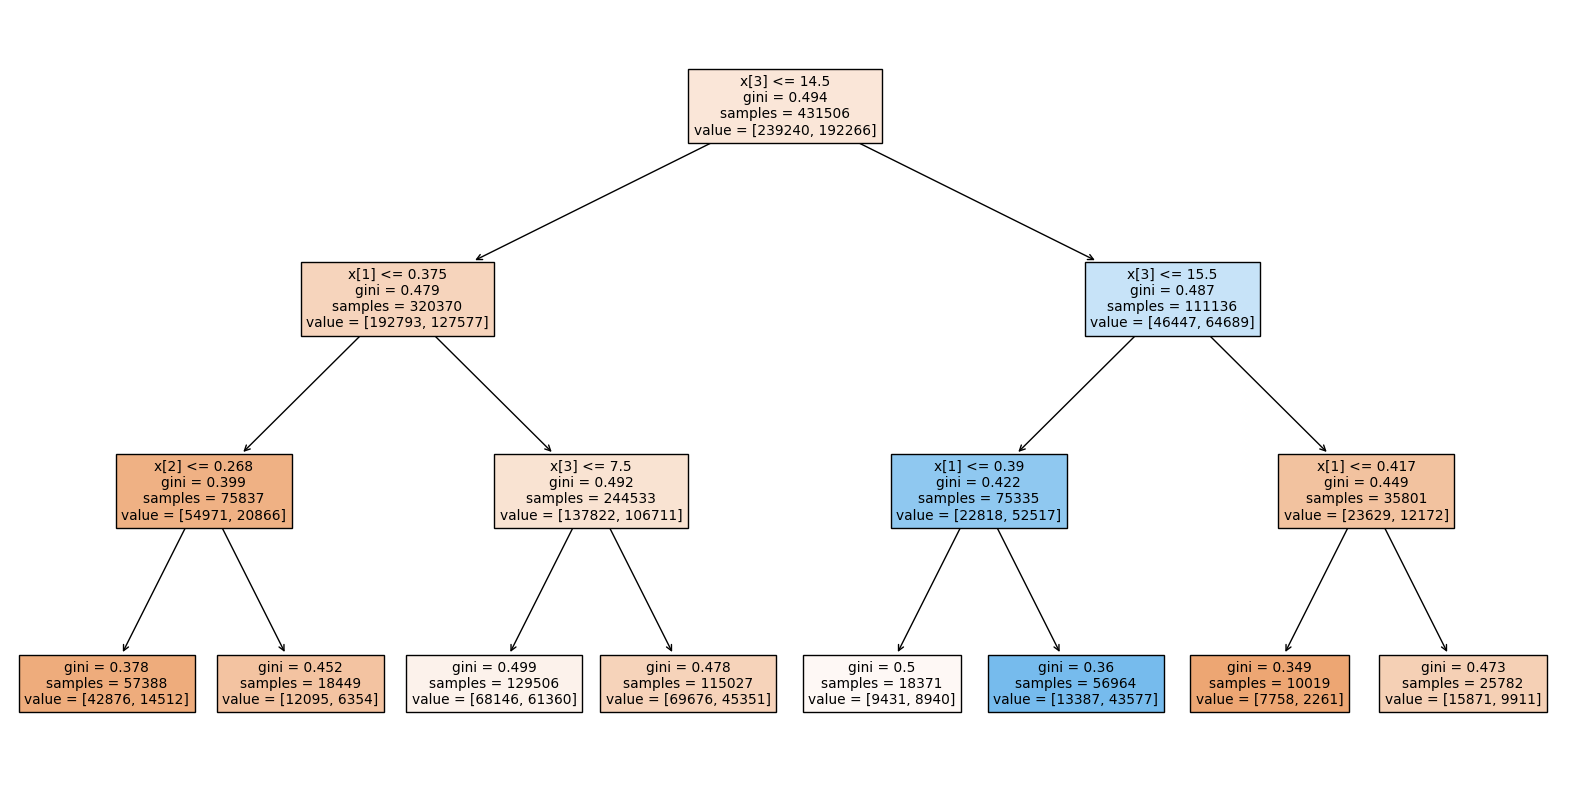

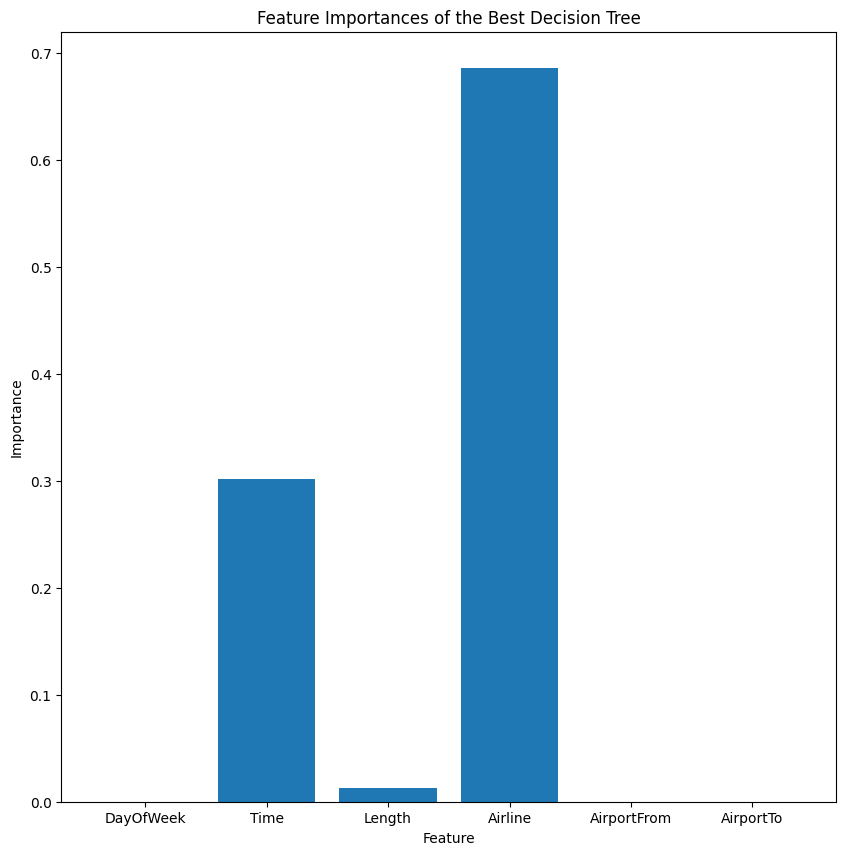

In [34]:
# Create an array to store results
results_array = []
accuracies = []
depths = []
cv_scores = []
higehstAccuracy = 0

# Specify the parameters for the random search
param_dist = {
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    #'min_samples_split': range(2, 3),
    #'min_samples_leaf': range(1, 2),
    'criterion': ['gini', 'entropy'],
    'n_jobs': [-1]
}

# Number of random samples
n_iter_search = 20

# Define the KFold for the outer loop
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)


# Loop through each depth and perform random search
for depth in range(1, 21):
    tree = DecisionTreeClassifier(random_state=42, max_depth=depth)
    
    random_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=n_iter_search, scoring='accuracy', cv=kfolds, random_state=42)
    random_search.fit(X_train, y_train)
    
    # Perform nested cross-validation
    cv_score = cross_val_score(random_search, X_train, y_train, cv=kfolds, scoring=make_scorer(accuracy_score))
    
    # Test on the other 20%
    clf = Pipeline([('classifier', random_search.best_estimator_)])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results in array
    results_array.append([depth, accuracy, cv_score.mean(), precision, recall, f1,random_search.best_params_])
    accuracies.append(accuracy)
    depths.append(depth)
    cv_scores.append(cv_score.mean())

    print(f"Depth: {results_array[-1][0]}, Accuracy: {results_array[-1][1]}, CV Accuracy: {results_array[-1][2]}, Precision: {results_array[-1][3]}, Recall: {results_array[-1][4]}, f1: {results_array[-1][5]}, Best Parameters: {results_array[-1][6]}")

    if higehstAccuracy < cv_scores[-1]:
        cm = confusion_matrix(y_test, y_pred)
        bestTree = clf
        importanceBest = clf['classifier'].feature_importances_

# plot the cm
plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot()
plt.savefig("Graphs/dtCM.pdf")
plt.show()
 
#plot for depth and accuracy
plt.plot(depths, accuracies, marker='o', label="CV Accuracy (20% Test Data)")
plt.plot(depths, cv_scores, marker='o', label="Nested CV Accuracy")
plt.legend()
plt.title('Max Depth vs. Accuracy and Cross-Validation Score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.savefig("Graphs/dtAccForDepths.pdf")
plt.show()
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(bestTree['classifier'], filled=True)
plt.savefig("Graphs/dtCV.pdf")
plt.show()
 
# Plotte die Feature-Importances mit den Namen der Features
plt.figure(figsize=(10, 10))
plt.bar([x for x in range(len(importanceBest))], importanceBest, tick_label=X_train.columns)
plt.title('Feature Importances of the Best Decision Tree')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig("Graphs/dtFeatureImportance.pdf")
plt.show()


As the Random Forest model is only a bit better in precision but the Decision Tree is better in f1 and better in the runtime, we finally decided on using the Decision Tree.

# Decision Tree with Random Search

We tried out Grid Search at first but the performance was not great so we changed it to random Search to increase performance.
Additionally, nested Cross Validation is implemented.

## Tim Random search without depth 

# Evaluation of the Decision Tree

## Cross validation

To have more precise measurements, we added cross validation to the model.

The Decision Tree only uses the columns "Flight" and "Airport To" for deciding. We used depth = 4 because at depth 5 it is overfitting as you can see on the accuracy graph.

## Confusion Matrix

And now, we wanted a visualization of the data that is predicted correct and that is predicted falsely. For that, we used a Confusion Matrix with the tree depth of 2 (according to the cross validation score).

The Confusion Matrix looks pretty good. In the most cases the model is able to predict that a flight will not be delayed when it actually is not delayed. It is true in about 77.8% of the cases. The prediction for a delayed flight is not that accurate. Only in about 45% of the cases the model's prediction is correct. 

## Columns

We now wanted to test on the different columns, whether they are really all needed for the Decision Tree model or not. For that, we used the Decision Tree with a depth of 2 (according to the cross validation score).

As you can see, the best accuracy with the fewest columns is actually only Airline.